In [1]:
# !pip install pystan
# !pip install fbprophet
# !pip install plotly
# !pip install ipywidgets


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json

def set_view(mrow=500, mcol=500, dwidth=1000, defaul=False, set_dw=False):
    """ sets display options """
    if not defaul:
        pd.set_option('display.max_rows', mrow)
        pd.set_option('display.max_columns', mcol)
        if set_dw:
            pd.set_option('display.width', dwidth)
    else:
        pd.set_option('display.max_rows', 10)
        pd.set_option('display.max_columns', 10)


In [2]:
df = pd.read_csv('Surat_all.csv')
df.columns

Index(['COMMODITY', 'VARIETY', 'ARRIVAL_DATE', 'MODAL_PRICE'], dtype='object')

In [3]:
df['ds'] = df['ARRIVAL_DATE'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
df['y'] = df['MODAL_PRICE'].apply(lambda x: int(x))
df = df.drop(['VARIETY', 'ARRIVAL_DATE', 'MODAL_PRICE'], axis= 1)
df.dtypes

COMMODITY            object
ds           datetime64[ns]
y                     int64
dtype: object

In [5]:
# dfl is list of dataframes of each commodity
dfl = [df[(df['COMMODITY'] == i)] for i in df['COMMODITY'].unique()]
for i in dfl: display(i.head())

,COMMODITY,ds,y
0,Pointed gourd (Parval),2016-01-19,6000
1,Pointed gourd (Parval),2016-01-21,5500
2,Pointed gourd (Parval),2016-01-22,5500
3,Pointed gourd (Parval),2016-01-28,5250
4,Pointed gourd (Parval),2016-01-29,5250


,COMMODITY,ds,y
2616,Onion,2015-01-05,1750
2617,Onion,2015-01-06,1500
2618,Onion,2015-01-07,1500
2619,Onion,2015-01-08,1500
2620,Onion,2015-01-09,1500


,COMMODITY,ds,y
3688,Peas cod,2013-01-02,1375
3689,Peas cod,2013-01-03,1325
3690,Peas cod,2013-01-04,1300
3691,Peas cod,2013-01-05,1350
3692,Peas cod,2013-01-07,1400


,COMMODITY,ds,y
6403,Cauliflower,2012-01-07,1250
6404,Cauliflower,2012-01-09,1400
6405,Cauliflower,2012-01-10,1450
6406,Cauliflower,2012-01-11,1400
6407,Cauliflower,2012-01-12,1450


,COMMODITY,ds,y
9603,Tomato,2007-01-02,700
9604,Tomato,2007-01-03,700
9605,Tomato,2007-01-04,600
9606,Tomato,2007-01-05,625
9607,Tomato,2007-01-06,600


,COMMODITY,ds,y
13068,Carrot,2018-01-01,1150
13069,Carrot,2018-01-02,1150
13070,Carrot,2018-01-03,1100
13071,Carrot,2018-01-04,1100
13072,Carrot,2018-01-05,1250


,COMMODITY,ds,y
15282,Cabbage,2018-01-01,975
15283,Cabbage,2018-01-02,950
15284,Cabbage,2018-01-03,975
15285,Cabbage,2018-01-04,1000
15286,Cabbage,2018-01-05,950


,COMMODITY,ds,y
18542,Bottle gourd,2014-01-03,700
18543,Bottle gourd,2014-01-04,600
18544,Bottle gourd,2014-01-06,600
18545,Bottle gourd,2014-01-07,600
18546,Bottle gourd,2014-01-09,600


,COMMODITY,ds,y
19737,Potato,2016-01-05,900
19738,Potato,2016-01-06,900
19739,Potato,2016-01-07,900
19740,Potato,2016-01-08,950
19741,Potato,2016-01-09,950


In [28]:
# ml is list of models
ml = [Prophet() for i in range(len(dfl))]
for i in range(len(dfl)): ml[i].fit(dfl[i])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
futurel = [ml[i].make_future_dataframe(periods=7) for i in range(len(dfl))]
for i in range(len(dfl)): futurel[i].tail()

In [30]:
# computationally intensive task
forecastl = [ml[i].predict(futurel[i]) for i in range(len(dfl))]
for i in range(len(dfl)): forecastl[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [12]:
# f2 = forecast.copy()
# f2['orj'] = pd.Series(df['y'].to_numpy())
def mod_pro(fcst, B, C, D, E):
    """input data must be atleast 14 days"""
    shift = len(fcst) % 7
    f2 = fcst.copy()
    for i in range(1, len(fcst)//7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7 + shift, (i)*7 + shift):
            if abs(fcst['yhat_lower'][j]-fcst['yhat_upper'][j])*B[0] < abs(fcst['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if fcst['yhat'][j]-df['y'][len(df)-1-j] < 0: upp += 1
            else: low += 1
        if cnt >= B[1]:
            for j in range((i)*7 + shift, (i+1)*7 + shift):
                f2['yhat'][j] = C[0] * fcst['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * (df['y'][len(df)-1-j+7] + E[0])
                if upp > low:
                    f2['yhat'][j] += D[0] * fcst['yhat_upper'][j] + D[1] * fcst['yhat_upper'][j-7]+ (f2['yhat'][j-1] * E[1])
                else:
                    f2['yhat'][j] += D[0] * fcst['yhat_lower'][j] + D[1] * fcst['yhat_lower'][j-7]- (f2['yhat'][j-1] * E[1])
    return f2


In [ ]:
# tst([0.2, 4], [0.1, 0.1, 0.6], [0.1, 0.1], [28, 0]) # for onion => rmse=356

In [31]:
for i in range(len(dfl)): print(dfl[i].iloc[1,0])

Pointed gourd (Parval)
Onion
Peas cod
Cauliflower
Tomato
Carrot
Cabbage
Bottle gourd
Potato


In [53]:
tst_on = mod_pro(forecastl[2], [0.4, 4], [0.3, 0.2, 0.3], [0.1, 0.1], [28, 0])

<ipython-input-12-b3f48e529f11>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-b3f48e529f11>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

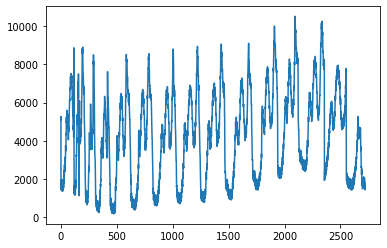

In [54]:
forecastl[2]['yhat'].plot()

In [55]:
plot_plotly(ml[2], forecastl[2])

In [56]:
plot_plotly(ml[2], tst_on)

In [15]:
tst_on['orj'] = dfl[1]['y']

<AxesSubplot:>

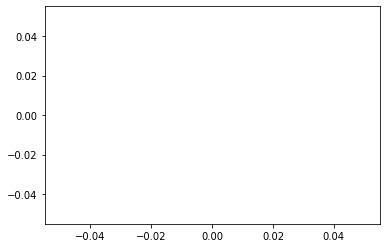

In [23]:
tst_on['orj'].plot()

<AxesSubplot:>

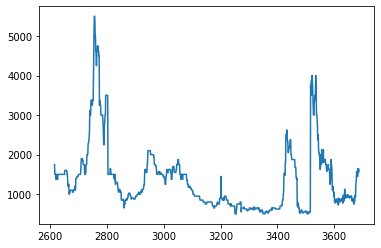

In [24]:
dfl[1]['y'].plot()


<AxesSubplot:>

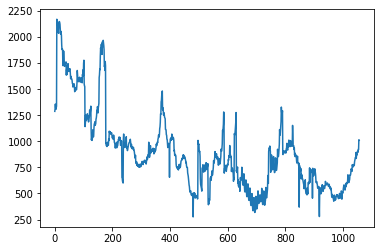

In [25]:
tst_on['yhat'].plot()

In [39]:

def tst(df, forecast, C1, C2, C, D, E):
    f2 = forecast.copy()
    f2['orj'] = pd.Series(df['y'].to_numpy())
    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][len(df)-1-j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * (df['y'][len(df)-1-j+7] + E[0])
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]+ (f2['yhat'][j-1] * E[1])
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]- (f2['yhat'][j-1] * E[1])
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return (f2['sqe'].sum()/len(f2['sqe']-7))**(1/2)


In [48]:
tst(dfl[2], forecastl[2], 0.2, 4, [0.1, 0.1, 0.6], [0.1, 0.1], [28, 0])

KeyError: 2714

In [45]:
[len(i) for i in dfl]

[2616, 1072, 2715, 3200, 3465, 2214, 3260, 1195, 2919]

In [47]:
[len(i) for i in forecastl]

[2623, 1057, 2722, 3192, 3471, 2199, 3246, 1184, 2925]